# <center> __COSC 3380 - Machine Learning I (Spring 2021)__ </center>

# <font color=green>*Capstone Project*</font>
### Student Name: Cory Munselle
### Date: 05/10/2021
### Description: Classify different songs based on genre


<font color=red>Before I begin training different models, I want to understand how librosa works and talk a bit about what information we'll be extracting from our music to train our models.</font>

In [1]:
import numpy as np
import pandas as pnd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn import preprocessing
import os
from PIL import Image
import pathlib
import csv
import librosa
import librosa.display
import IPython.display as ipd

test_audio = './Music Genres Dataset/genres/blues/blues.00000.wav'

y, sr = librosa.load(test_audio, sr=None)

ipd.Audio(test_audio)

<font color='red'>This is just a test to show how loading works in librosa as well as displaying how IPython has built-in audio display features. It's also verification that the file is properly being loaded.</font>

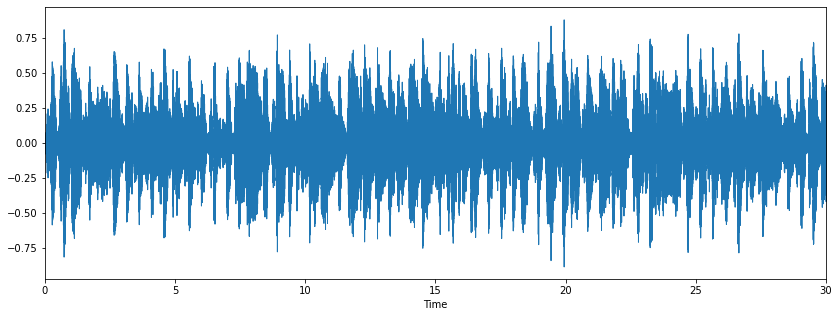

In [13]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

<font color='red'>Graphing seems to work through librosa's built in display functionality. What's interesting is how it's mapped: the left part represents the amplitude envelope, which is the change in amplitude of a sound over time. The envelope is mapped between 0 and 1 inclusive, represented the relative 'strength' of the sound wave.</font>

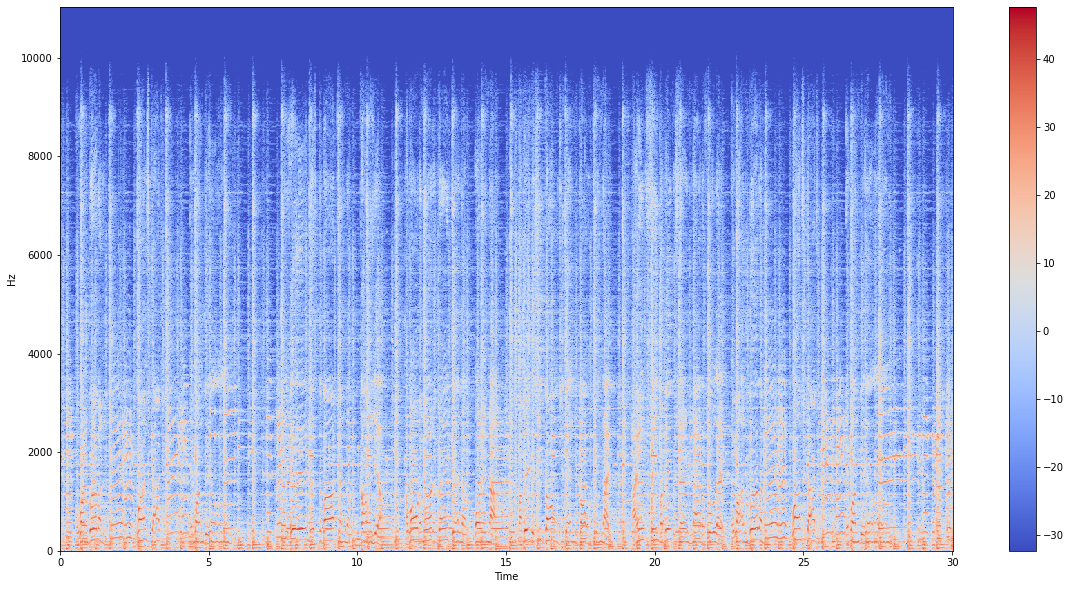

In [16]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 10))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

<font color='red'>This is a spectrogram, which is a colored representation of the different frequencies of any given sound. Spectrograms are displayed as a heatmap, with the more red sections of the spectrogram being more intense. Given the representation of our blues song, we can tell that most of the sound resides on the lower end of the frequency spectrum.</font>

16


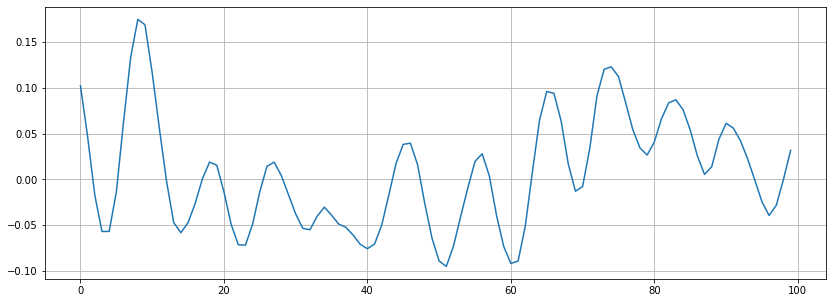

In [22]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(y[n0:n1])
plt.grid()

zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

<font color='red'>This a graph of the zero crossing rate, or the number of times the song goes from a positive amplitude to a negative one. This can be viewed as a 'gap' in the sound, as the sound wave goes from a peak to a trough and the air fills in the gap that the instrument displaced. Songs with many percussive instruments often have many zero crossings, because the sound is generated in bursts from striking, so we can use this to identify music with strong percussive elements. 

As a note, this graph is a zoomed in version of the entire song, so it's not necessarily representative of the entire song. This is just for demonstration purposes.</font>

In [23]:
zero_crossings = librosa.zero_crossings(y, pad=False)
print(sum(zero_crossings))

55031


<font color='red'>As you can see, it crosses the zero line a *lot*. However, we can expect this number to be much higher in songs with heavier percussion, like rock.</font>

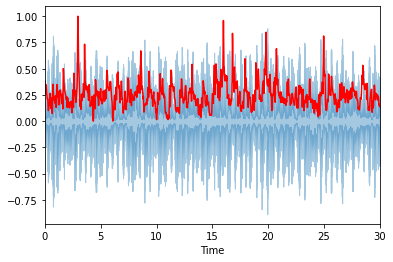

In [31]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(y, axis=0):
    return preprocessing.minmax_scale(y, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

<font color='red'>The Spectral Centroids are a bit complicated to explain, but to put it simply it is the weighted mean of the frequencies of sound. It represents the 'center of mass' for a song, and is very closely correlated with brightness in sound (namely songs that have stronger treble). For a blues song, that doesn't have too many high frequency moments, the center of mass is hard to make out because it remains consistent throughout the song. It would be much more noticable with brighter instruments like clarinets and violins.</font>


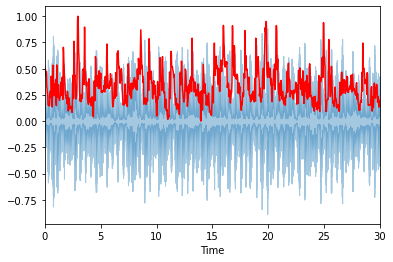

In [32]:
spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

<font color='red'>This is the spectral rolloff of the signal, which is the 'shape' of the signal. This needs expanding.</font>

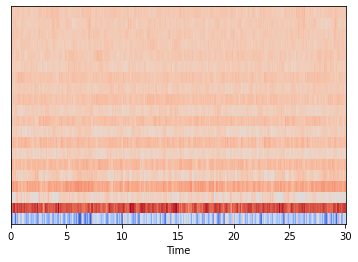

In [35]:
mfccs = librosa.feature.mfcc(y, sr=sr)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

C:\Users\Cory\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Cory\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


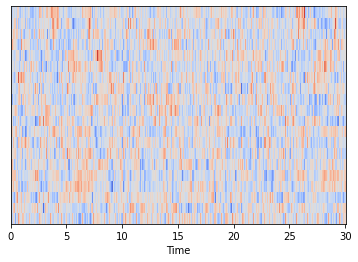

In [37]:
mfccs = preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

<font color='red'>These are called MFCCs, or Mel-frequency cepstrum coefficients. They are a complex transformation of sound to give a representation of the short-term power spectrum of a sound, and are very useful for identifying vocals in audio. They mimic the human voice in a lot of ways. As a note, these graphs look legitimately terrible and don't represent much visually. The important part is the data itself.</font>

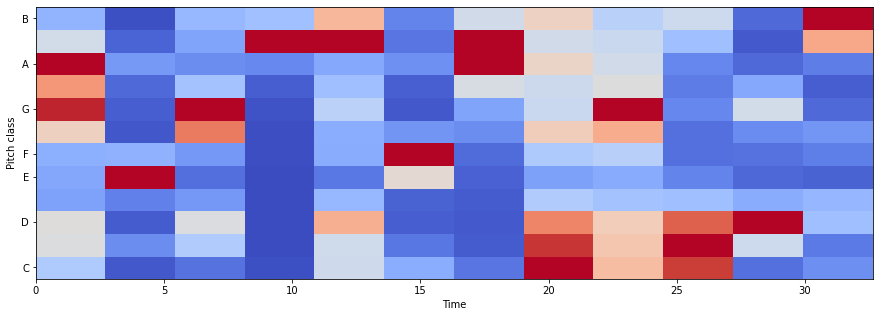

In [43]:
hop_length = 60000
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

<font color='red'>This is a chromagram, a graph that represents the various pitches that any song plays at a given time. The idea is simply to translate the frequency into one of the 12 semitones in an octave and plot it onto a heatmap, with the red colors being the pitch being hit. The closer you get to blue, the less present the note is. It's a great way to translate a spectrum into something that exists in a more traditional musical environment. </font>

In [2]:
#Credit goes to Parul Pandey for the quick and dirty loading code to get the csv file made.
#https://gist.github.com/parulnith/7f8c174e6ac099e86f0495d3d9a4c01e#file-music_genre_classification-ipynb

header = 'tempo chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('music_data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./Music Genres Dataset/genres/{g}'):
        songname = f'./Music Genres Dataset/genres/{g}/{filename}'
        y, sr = librosa.load(songname, sr=None, mono=True, duration=30)
        tempo = librosa.beat.tempo(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{np.mean(tempo)} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('music_data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

<font color='red'>This code above takes all of the files, processes them, and puts it in a csv file that I can load in later so I don't have to constantly reload the files. This should save space and processing time overall.</font>

In [4]:
musicData = pnd.read_csv('music_data.csv', header=0)

musicData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempo               1000 non-null   float64
 1   chroma_stft         1000 non-null   float64
 2   rms                 1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

In [5]:
#We're going to encode the labels for future use. It may be useful, but I'll put it in a numpy array in case it isn't.
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(musicData['label'])

print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [6]:
#Now to separate the rest and put it in a dataframe so we can make a train/test split on the data
#I'm not going to be standard scaling any of the data yet because I want to see how well things perform without it

X = musicData.drop(columns=['label'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempo               1000 non-null   float64
 1   chroma_stft         1000 non-null   float64
 2   rms                 1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

In [7]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size = 0.2, random_state=42)

len(features_train)

len(labels_train)

800

<font color='red'>Now that a training and testing dataset have been created, we're going to try throwing it against a few models to see how well it performs. Ensembling is going to be done in the future, but I want to isolate the best performing algorithms first.</font>

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error

RFModel = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=1)
RFModel.fit(features_train, labels_train)

RFScore = RFModel.score(features_train, labels_train)
print("Base training score: %.5f" % RFScore)
RFScore = RFModel.score(features_test, labels_test)
print("Base testing score: %.5f" % RFScore)

predictions = RFModel.predict(features_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
print('Accuracy:', accuracy_score(labels_test, predictions))
print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))

Base training score: 0.79750
Base testing score: 0.50500
Mean Absolute Error (MAE): 1.955
Accuracy: 0.505
              precision    recall  f1-score   support

       blues       0.33      0.30      0.32        20
   classical       0.87      1.00      0.93        13
     country       0.50      0.15      0.23        27
       disco       0.50      0.38      0.43        21
      hiphop       0.33      0.60      0.43        15
        jazz       0.59      0.77      0.67        22
       metal       0.56      0.88      0.69        25
         pop       0.43      0.46      0.44        13
      reggae       0.58      0.48      0.52        23
        rock       0.33      0.24      0.28        21

    accuracy                           0.51       200
   macro avg       0.50      0.53      0.49       200
weighted avg       0.50      0.51      0.48       200



<font color='red'>A respectable result! For no scaling 48.5% accuracy is better than I would have expected, although we can definitely alter a few things in the future to refine this. That's for later, though: lets continue with different algorithms.</font>

In [12]:
from sklearn.ensemble import ExtraTreesClassifier

ETClass = ExtraTreesClassifier(n_estimators=1000, random_state=1)
ETClass.fit(features_train, labels_train)

ETScore = ETClass.score(features_train, labels_train)
print("Base training score: %.5f" % ETScore)
ETScore = ETClass.score(features_test, labels_test)
print("Base testing score: %.5f" % ETScore)

predictions = ETClass.predict(features_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
print('Accuracy:', accuracy_score(labels_test, predictions))
print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))

Base training score: 0.99875
Base testing score: 0.66000
Mean Absolute Error (MAE): 1.465
Accuracy: 0.66
              precision    recall  f1-score   support

       blues       0.75      0.60      0.67        20
   classical       0.81      1.00      0.90        13
     country       0.67      0.74      0.70        27
       disco       0.71      0.57      0.63        21
      hiphop       0.41      0.47      0.44        15
        jazz       0.75      0.82      0.78        22
       metal       0.74      0.92      0.82        25
         pop       0.50      0.62      0.55        13
      reggae       0.59      0.43      0.50        23
        rock       0.56      0.43      0.49        21

    accuracy                           0.66       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



<font color='red'>This result was quite a bit better than Random Forests, which is a good sign. It's indicating that Extra Trees might be a better choice over Random Forests for our future ensemble, but I'm going to run a few more algorithms before I say that.</font>

In [13]:
from sklearn.neighbors import KNeighborsClassifier

KNModel = KNeighborsClassifier()
KNModel.fit(features_train, labels_train)

KNScore = KNModel.score(features_train, labels_train)
print("Base training score: %.5f" % KNScore)
KNScore = KNModel.score(features_test, labels_test)
print("Base testing score: %.5f" % KNScore)

predictions = KNModel.predict(features_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
print('Accuracy:', accuracy_score(labels_test, predictions))
print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))

Base training score: 0.55375
Base testing score: 0.31000
Mean Absolute Error (MAE): 2.415
Accuracy: 0.31
              precision    recall  f1-score   support

       blues       0.31      0.40      0.35        20
   classical       0.79      0.85      0.81        13
     country       0.17      0.15      0.16        27
       disco       0.19      0.24      0.21        21
      hiphop       0.11      0.20      0.14        15
        jazz       0.27      0.18      0.22        22
       metal       0.57      0.64      0.60        25
         pop       0.36      0.38      0.37        13
      reggae       0.29      0.17      0.22        23
        rock       0.18      0.10      0.12        21

    accuracy                           0.31       200
   macro avg       0.32      0.33      0.32       200
weighted avg       0.31      0.31      0.30       200



<font color='red'>Hmm, looks like the worst result so far. I can't say I'm surprised, if only because KNN is at a disadvantage compared to the previous two (they're both technically ensemble methods). However, I'm not going to count it out yet!</font>

In [27]:
from sklearn.svm import SVC

SVCModel = SVC(kernel='linear', probability=True)
SVCModel.fit(features_train, labels_train)

SVCscore = SVCModel.score(features_train, labels_train)
print("Base training score: %.5f" % SVCscore)
SVCscore = SVCModel.score(features_test, labels_test)
print("Base testing score: %.5f" % SVCscore)

predictions = SVCModel.predict(features_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
print('Accuracy:', accuracy_score(labels_test, predictions))
print(classification_report(labels_test, predictions, target_names=label_encoder.inverse_transform(range(0,10)), zero_division=True))

Base training score: 0.78500
Base testing score: 0.51000
Mean Absolute Error (MAE): 2.125
Accuracy: 0.51
              precision    recall  f1-score   support

       blues       0.36      0.60      0.45        20
   classical       0.80      0.92      0.86        13
     country       0.43      0.44      0.44        27
       disco       0.55      0.52      0.54        21
      hiphop       0.30      0.40      0.34        15
        jazz       0.65      0.50      0.56        22
       metal       0.80      0.80      0.80        25
         pop       0.50      0.62      0.55        13
      reggae       0.62      0.35      0.44        23
        rock       0.15      0.10      0.12        21

    accuracy                           0.51       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.51      0.50       200



<font color='red'>This is a solid result too. I'm noticing a pattern start to occur, where most of the algorithms seem to excel at genres like classical but only Extra Trees has really gotten anywhere close to accurate with rock. 
    
Given the cheat sheet, I think these algorithms we've tried are the most appropriate for our application. In this instance, I think it would be best to try standard scaling some of the data to hopefully get better results.</font>

In [8]:
standard_scaler = preprocessing.StandardScaler()

X_scaled = standard_scaler.fit_transform(X)

scaledMusicData = pnd.DataFrame(X_scaled, columns=X.columns)

scaledMusicData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempo               1000 non-null   float64
 1   chroma_stft         1000 non-null   float64
 2   rms                 1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

In [18]:
import scikitplot as skplt

def model_metrics(y_test,y_pred):
    print("Decoded genres after applying inverse of label encoder : " + str(np.unique(y_pred)))
    skplt.metrics.plot_confusion_matrix(y_test,y_pred,text_fontsize="small",cmap='Greens',figsize=(10,8))
    plt.show()
    print("The classification report for the model : \n\n"+ classification_report(y_test, y_pred))

In [10]:
#Make new splits based on new scaled data
features_train, features_test, labels_train, labels_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)

Base training score: 0.79750
Base testing score: 0.50500
Mean Absolute Error (MAE): 1.955
Accuracy: 0.505
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


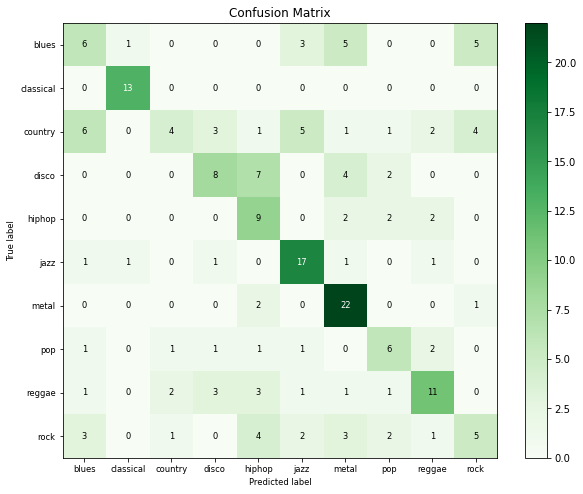

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.33      0.30      0.32        20
   classical       0.87      1.00      0.93        13
     country       0.50      0.15      0.23        27
       disco       0.50      0.38      0.43        21
      hiphop       0.33      0.60      0.43        15
        jazz       0.59      0.77      0.67        22
       metal       0.56      0.88      0.69        25
         pop       0.43      0.46      0.44        13
      reggae       0.58      0.48      0.52        23
        rock       0.33      0.24      0.28        21

    accuracy                           0.51       200
   macro avg       0.50      0.53      0.49       200
weighted avg       0.50      0.51      0.48       200



In [19]:
RFModel = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=1)
RFModel.fit(features_train, labels_train)

RFScore = RFModel.score(features_train, labels_train)
print("Base training score: %.5f" % RFScore)
RFScore = RFModel.score(features_test, labels_test)
print("Base testing score: %.5f" % RFScore)

predictions = RFModel.predict(features_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
print('Accuracy:', accuracy_score(labels_test, predictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(predictions)
model_metrics(y_test,y_pred_nb)

Base training score: 0.99875
Base testing score: 0.66000
Mean Absolute Error (MAE): 1.465
Accuracy: 0.66
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


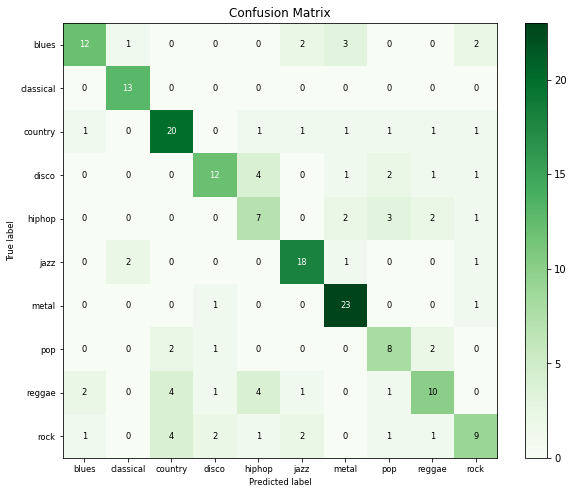

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.75      0.60      0.67        20
   classical       0.81      1.00      0.90        13
     country       0.67      0.74      0.70        27
       disco       0.71      0.57      0.63        21
      hiphop       0.41      0.47      0.44        15
        jazz       0.75      0.82      0.78        22
       metal       0.74      0.92      0.82        25
         pop       0.50      0.62      0.55        13
      reggae       0.59      0.43      0.50        23
        rock       0.56      0.43      0.49        21

    accuracy                           0.66       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



In [24]:
ETClass = ExtraTreesClassifier(n_estimators=1000, random_state=1)
ETClass.fit(features_train, labels_train)

ETScore = ETClass.score(features_train, labels_train)
print("Base training score: %.5f" % ETScore)
ETScore = ETClass.score(features_test, labels_test)
print("Base testing score: %.5f" % ETScore)

predictions = ETClass.predict(features_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
print('Accuracy:', accuracy_score(labels_test, predictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(predictions)
model_metrics(y_test,y_pred_nb)

Base training score: 0.55375
Base testing score: 0.31000
Mean Absolute Error (MAE): 2.415
Accuracy: 0.31
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


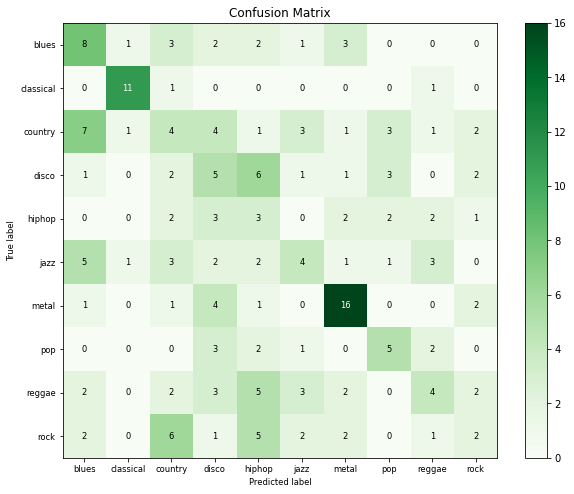

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.31      0.40      0.35        20
   classical       0.79      0.85      0.81        13
     country       0.17      0.15      0.16        27
       disco       0.19      0.24      0.21        21
      hiphop       0.11      0.20      0.14        15
        jazz       0.27      0.18      0.22        22
       metal       0.57      0.64      0.60        25
         pop       0.36      0.38      0.37        13
      reggae       0.29      0.17      0.22        23
        rock       0.18      0.10      0.12        21

    accuracy                           0.31       200
   macro avg       0.32      0.33      0.32       200
weighted avg       0.31      0.31      0.30       200



In [25]:
from sklearn.neighbors import KNeighborsClassifier

KNModel = KNeighborsClassifier()
KNModel.fit(features_train, labels_train)

KNScore = KNModel.score(features_train, labels_train)
print("Base training score: %.5f" % KNScore)
KNScore = KNModel.score(features_test, labels_test)
print("Base testing score: %.5f" % KNScore)

predictions = KNModel.predict(features_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
print('Accuracy:', accuracy_score(labels_test, predictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(predictions)
model_metrics(y_test,y_pred_nb)

Base training score: 0.78500
Base testing score: 0.51000
Mean Absolute Error (MAE): 2.125
Accuracy: 0.51
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


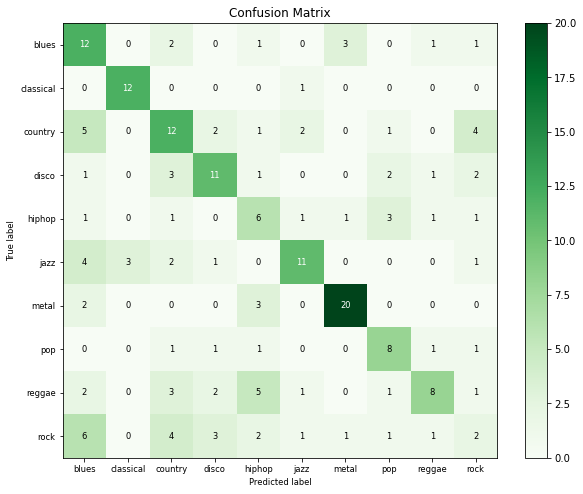

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.36      0.60      0.45        20
   classical       0.80      0.92      0.86        13
     country       0.43      0.44      0.44        27
       disco       0.55      0.52      0.54        21
      hiphop       0.30      0.40      0.34        15
        jazz       0.65      0.50      0.56        22
       metal       0.80      0.80      0.80        25
         pop       0.50      0.62      0.55        13
      reggae       0.62      0.35      0.44        23
        rock       0.15      0.10      0.12        21

    accuracy                           0.51       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.51      0.50       200



In [28]:
SVCModel = SVC(kernel='linear', probability=True)
SVCModel.fit(features_train, labels_train)

SVCscore = SVCModel.score(features_train, labels_train)
print("Base training score: %.5f" % SVCscore)
SVCscore = SVCModel.score(features_test, labels_test)
print("Base testing score: %.5f" % SVCscore)

predictions = SVCModel.predict(features_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(labels_test, predictions))
print('Accuracy:', accuracy_score(labels_test, predictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(predictions)
model_metrics(y_test,y_pred_nb)

<font color='red'>Wow, the KNN model improved a significant amount after standardizing the data, and it looks like none of the other algorithms had any worse performance as a result! Out of the ones we tried, it looks like our best options are Extra Trees, SVC, and KNN for our ensemble. Let's try it!</font>

Base training score: 0.89875
Base validation score: 0.56
Accuracy: 0.56
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


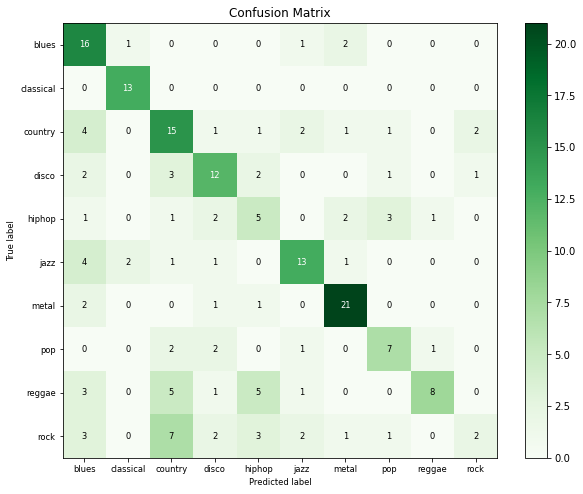

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.46      0.80      0.58        20
   classical       0.81      1.00      0.90        13
     country       0.44      0.56      0.49        27
       disco       0.55      0.57      0.56        21
      hiphop       0.29      0.33      0.31        15
        jazz       0.65      0.59      0.62        22
       metal       0.75      0.84      0.79        25
         pop       0.54      0.54      0.54        13
      reggae       0.80      0.35      0.48        23
        rock       0.40      0.10      0.15        21

    accuracy                           0.56       200
   macro avg       0.57      0.57      0.54       200
weighted avg       0.57      0.56      0.54       200



In [29]:
from sklearn.ensemble import VotingClassifier

VoteModel = VotingClassifier(
    estimators=[('et', ETClass), ('kn', KNModel), ('svc', SVCModel)],
    voting='hard')
VoteModel.fit(features_train, labels_train)
VoteScore = VoteModel.score(features_train, labels_train)
print("Base training score:", VoteScore)
VoteScore = VoteModel.score(features_test, labels_test)
print("Base validation score:", VoteScore)

Votepredictions = VoteModel.predict(features_test)

print('Accuracy:', accuracy_score(labels_test, Votepredictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(Votepredictions)
model_metrics(y_test,y_pred_nb)

Base training score: 0.99875
Base validation score: 0.53
Accuracy: 0.53
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


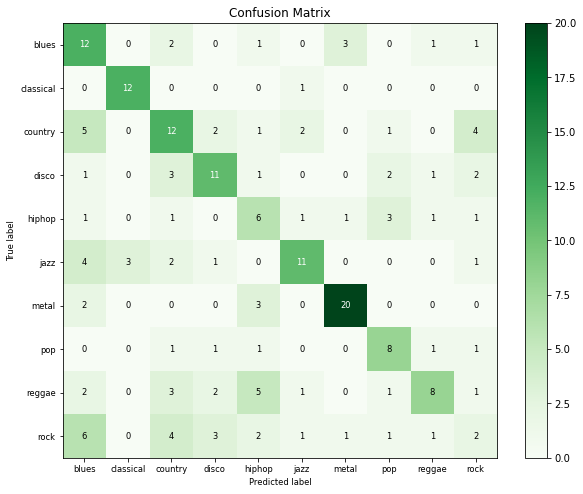

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.36      0.60      0.45        20
   classical       0.80      0.92      0.86        13
     country       0.43      0.44      0.44        27
       disco       0.55      0.52      0.54        21
      hiphop       0.30      0.40      0.34        15
        jazz       0.65      0.50      0.56        22
       metal       0.80      0.80      0.80        25
         pop       0.50      0.62      0.55        13
      reggae       0.62      0.35      0.44        23
        rock       0.15      0.10      0.12        21

    accuracy                           0.51       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.51      0.50       200

Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


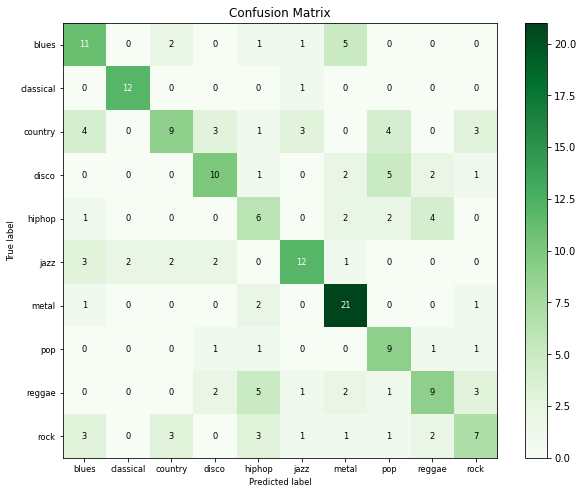

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.48      0.55      0.51        20
   classical       0.86      0.92      0.89        13
     country       0.56      0.33      0.42        27
       disco       0.56      0.48      0.51        21
      hiphop       0.30      0.40      0.34        15
        jazz       0.63      0.55      0.59        22
       metal       0.62      0.84      0.71        25
         pop       0.41      0.69      0.51        13
      reggae       0.50      0.39      0.44        23
        rock       0.44      0.33      0.38        21

    accuracy                           0.53       200
   macro avg       0.53      0.55      0.53       200
weighted avg       0.54      0.53      0.52       200



In [30]:
VoteModel = VotingClassifier(
    estimators=[('et', ETClass), ('kn', KNModel), ('svc', SVCModel)],
    voting='soft')
VoteModel.fit(features_train, labels_train)
VoteScore = VoteModel.score(features_train, labels_train)
print("Base training score:", VoteScore)
VoteScore = VoteModel.score(features_test, labels_test)
print("Base validation score:", VoteScore)

Votepredictions = VoteModel.predict(features_test)

print('Accuracy:', accuracy_score(labels_test, Votepredictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(predictions)
model_metrics(y_test,y_pred_nb)

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(Votepredictions)
model_metrics(y_test,y_pred_nb)

<font color='red'>Hmm, doesn't look like our ensemble method really improved anything that much. 67% isn't terrible, but I'm curious to see if we can squeeze out more accuracy. Since the score isn't much higher than Extra Trees, how about we try bagging with Extra Trees to see if we can get a better result?</font>

Base training score: 0.9025
Base validation score: 0.545
Accuracy: 0.545
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


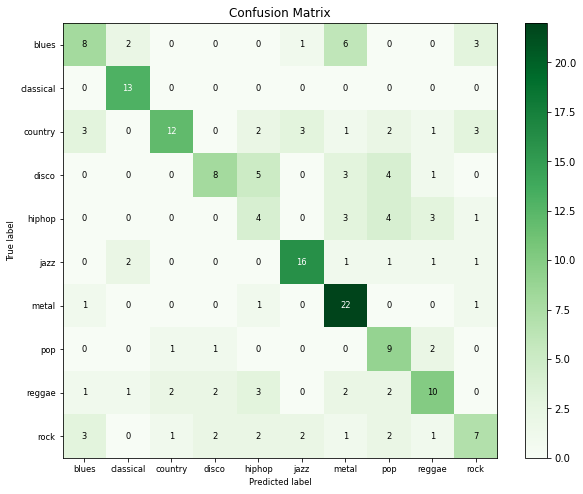

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.50      0.40      0.44        20
   classical       0.72      1.00      0.84        13
     country       0.75      0.44      0.56        27
       disco       0.62      0.38      0.47        21
      hiphop       0.24      0.27      0.25        15
        jazz       0.73      0.73      0.73        22
       metal       0.56      0.88      0.69        25
         pop       0.38      0.69      0.49        13
      reggae       0.53      0.43      0.48        23
        rock       0.44      0.33      0.38        21

    accuracy                           0.55       200
   macro avg       0.55      0.56      0.53       200
weighted avg       0.56      0.55      0.53       200



In [31]:
from sklearn.ensemble import BaggingClassifier

BagModel = BaggingClassifier(
    ExtraTreesClassifier(), n_estimators=500,
    max_samples=100, bootstrap=False, n_jobs=-1)
BagModel.fit(features_train, labels_train)
BagScore = BagModel.score(features_train, labels_train)
print("Base training score:", BagScore)
BagScore = BagModel.score(features_test, labels_test)
print("Base validation score:", BagScore)

predictions = BagModel.predict(features_test)

print('Accuracy:', accuracy_score(labels_test, predictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(predictions)
model_metrics(y_test,y_pred_nb)

<font color='red'>Hmm, that's a worse score than the initial Extra Trees we ran. I tested both bagging and pasting, with pasting getting a slightly better score, but neither result competes with either the initial Extra Trees classifier or the voting ensemble methods. Could the issue be with Extra Trees, since it's already an ensemble? Let's test with KNN...</font>

Base training score: 0.3725
Base validation score: 0.285
Accuracy: 0.285
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'metal' 'pop' 'reggae'
 'rock']


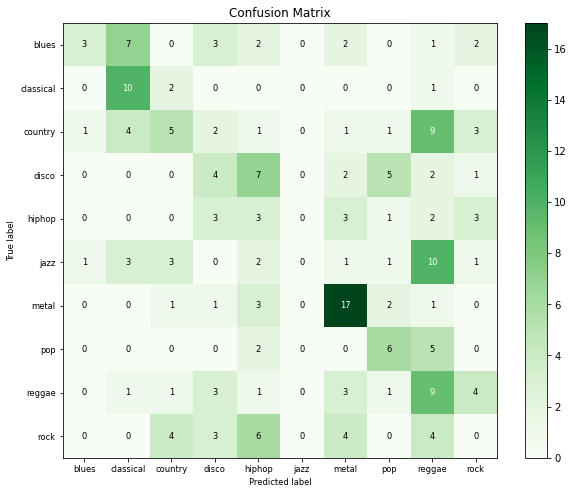

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.60      0.15      0.24        20
   classical       0.40      0.77      0.53        13
     country       0.31      0.19      0.23        27
       disco       0.21      0.19      0.20        21
      hiphop       0.11      0.20      0.14        15
        jazz       0.00      0.00      0.00        22
       metal       0.52      0.68      0.59        25
         pop       0.35      0.46      0.40        13
      reggae       0.20      0.39      0.27        23
        rock       0.00      0.00      0.00        21

    accuracy                           0.28       200
   macro avg       0.27      0.30      0.26       200
weighted avg       0.27      0.28      0.25       200



C:\Users\Cory\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
BagModel = BaggingClassifier(
    KNeighborsClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
BagModel.fit(features_train, labels_train)
BagScore = BagModel.score(features_train, labels_train)
print("Base training score:", BagScore)
BagScore = BagModel.score(features_test, labels_test)
print("Base validation score:", BagScore)

predictions = BagModel.predict(features_test)

print('Accuracy:', accuracy_score(labels_test, predictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(predictions)
model_metrics(y_test,y_pred_nb)

<font color='red'>Ouch, this is an even worse result. I think my only real option now would be to try some boosting to see if that yields better results.</font>

Base training score: 0.99875
Accuracy: 0.68
Decoded genres after applying inverse of label encoder : ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


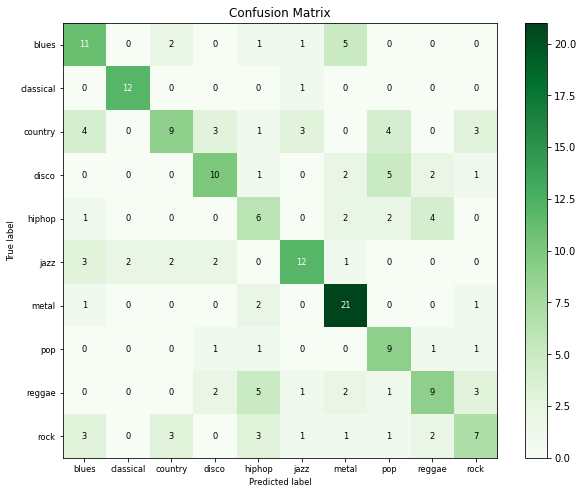

The classification report for the model : 

              precision    recall  f1-score   support

       blues       0.48      0.55      0.51        20
   classical       0.86      0.92      0.89        13
     country       0.56      0.33      0.42        27
       disco       0.56      0.48      0.51        21
      hiphop       0.30      0.40      0.34        15
        jazz       0.63      0.55      0.59        22
       metal       0.62      0.84      0.71        25
         pop       0.41      0.69      0.51        13
      reggae       0.50      0.39      0.44        23
        rock       0.44      0.33      0.38        21

    accuracy                           0.53       200
   macro avg       0.53      0.55      0.53       200
weighted avg       0.54      0.53      0.52       200



In [38]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoost = AdaBoostClassifier(
    ExtraTreesClassifier(), n_estimators=10,
    algorithm="SAMME.R", learning_rate=0.35)
AdaBoost.fit(features_train, labels_train)

AdaScore = AdaBoost.score(features_train, labels_train)
print("Base training score:", AdaScore)

predictions = AdaBoost.predict(features_test)

print('Accuracy:', accuracy_score(labels_test, predictions))

y_test = label_encoder.inverse_transform(labels_test)
y_pred_nb = label_encoder.inverse_transform(Votepredictions)
model_metrics(y_test,y_pred_nb)

## *Lessons Learned*

Use this section to document any lessons learned or issues you encountered and how you solved them